`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 

В практических примерах ниже показано:   

* как снижать размерность пространства признаков методами главных компонент (PCR), частных наименьшах квадратов (PLS)  
* как строить логистическую регрессию с регуляризацией параметров (методы ридж и лассо) 

Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 
*Данные*: `Wines` (источник: [репозиторий к книге С.Рашки Python и машинное обучение, глава 4](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch04))

# Указания к выполнению


## Загружаем пакеты

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# константы
#  ядро для генератора случайных чисел
my_seed = 20
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [3]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

Набор данных `wine` можно загрузить напрямую из пакета `sklearn` (набор впервые выложен [на сайте Калифорнийского университета в Ирвине](http://archive.ics.uci.edu/ml/datasets/Wine)). Таблица содержит результаты химического анализа вин, выращенных в одном регионе Италии тремя разными производителями. Большинство столбцов таблицы отражают содержание в вине различных веществ:   

* `alcohol` – алкоголь, процентное содержание;  
* `malic_acid` – яблочная кислота (разновидность кислоты с сильной кислотностью и ароматом яблока);  
* `ash` – зола (неорганическая соль, оказывающая влияние на вкус и придающая вину ощущение свежести);  
* `alcalinity_of_ash` – щелочность золы;  
* `magnesium` – магний (важный для организма слабощелочной элемент, способствующий энергетическому обмену);  
* `total_phenols` – всего фенола (молекулы, содержащие полифенольные вещества; имеют горький вкус, также влияют на цвет, относятся к питательным веществам в вине);  
* `flavanoids` – флаваноиды (полезный антиоксидант, даёт богатый аромат и горький вкус);  
* `nonflavanoid_phenols` – фенолы нефлаваноидные (специальный ароматический газ, устойчивый к окислению);  
* `proanthocyanins` – проантоцианы (биофлавоноидное соединение, которое также является природным антиоксидантом с легким горьковатым запахом); 
* `color_intensity` – интенсивность цвета; 
* `hue` – оттенок (мера яркости цвета, используется в т.ч. для измерения возраста вина); 
* `od280/od315_of_diluted_wines` – OD280/OD315 разбавленных вин (метод определения концентрации белка); 
* `proline` – пролин (основная аминокислота в красном вине, важный фактор вкуса и аромата); 
* `target` – целевая переменная: класс вина.   

Загружаем данные во фрейм и выясняем их размерность.  

## If you choose to work in Colab,

1. Visit [Drive folder](https://drive.google.com/drive/folders/1E9_u-v8chGmPwgROBEorD9hT609ysv_W?usp=sharing).

2. Right click on folder name -> "Add a shortcut to Drive" -> select "My Drive" -> "Add shortcut".

In [4]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# AUX_DATA_ROOT is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/data")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Mounted at /content/drive


In [5]:
# загружаем таблицу и превращаем её во фрейм
import os 

DF_all = pd.read_csv(os.path.join(AUX_DATA_ROOT, 'default_of_credit_card_clients.csv'))

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [6]:
# удаляем ненужные объясняющие переменные
DF_all = DF_all.drop('PAY_3', 1)
DF_all = DF_all.drop('PAY_4', 1)
DF_all = DF_all.drop('PAY_5', 1)
DF_all = DF_all.drop('PAY_6', 1)
DF_all = DF_all.drop('BILL_AMT3', 1)
DF_all = DF_all.drop('BILL_AMT4', 1)
DF_all = DF_all.drop('BILL_AMT5', 1)
DF_all = DF_all.drop('BILL_AMT6', 1)

In [7]:
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 16)


In [8]:
DF_all.head (5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,3913,3102,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,2682,1725,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,29239,14027,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,46990,48233,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,8617,5670,2000,36681,10000,9000,689,679,0


Отложим 15% наблюдений для прогноза (теста).  

In [9]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [10]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
BILL_AMT1    int64
BILL_AMT2    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [11]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
BILL_AMT1    0
BILL_AMT2    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

Пропусков не обнаружено.  

# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `Y`.  

In [12]:
# метки классов
DF.Y.unique()

array([0, 1])

In [13]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.779
1    0.221
Name: Y, dtype: float64

Всего 2 целевых класса, их доли сильно различаются

Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.  

In [14]:
# описательные статистики
DF.iloc[:, :6].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,168077.242353,1.604235,1.851255,1.551294,35.486471,-0.015608
std,129837.678356,0.489024,0.794329,0.521242,9.213824,1.126387
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000


In [15]:
# описательные статистики
DF.iloc[:, 6:11].describe()

,PAY_2,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2
count,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04
mean,-0.131882,51399.370471,49355.392471,5699.709020,5.963576e+03
std,1.201093,73891.950872,71405.114321,16687.930104,2.327991e+04
min,-2.000000,-165580.000000,-69777.000000,0.000000,0.000000e+00
25%,-1.000000,3538.500000,2983.000000,1000.000000,8.500000e+02
50%,0.000000,22407.000000,21241.500000,2103.000000,2.010000e+03
75%,0.000000,67255.750000,64150.000000,5019.000000,5.000000e+03
max,8.000000,653062.000000,743970.000000,873552.000000,1.684259e+06


In [16]:
# описательные статистики
DF.iloc[:, 11:15].describe()

,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,25500.000000,25500.000000,25500.000000,25500.000000
mean,5221.213333,4820.416824,4850.173843,5255.832627
std,16875.401546,15353.273877,15584.945606,17773.623966
min,0.000000,0.000000,0.000000,0.000000
25%,390.000000,298.000000,265.000000,133.000000
50%,1800.000000,1500.000000,1500.000000,1500.000000
75%,4523.250000,4030.750000,4078.000000,4045.250000
max,889043.000000,621000.000000,426529.000000,528666.000000


Выводы по описательным статистикам: есть отрицательные значения объясняющих переменных, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 15 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

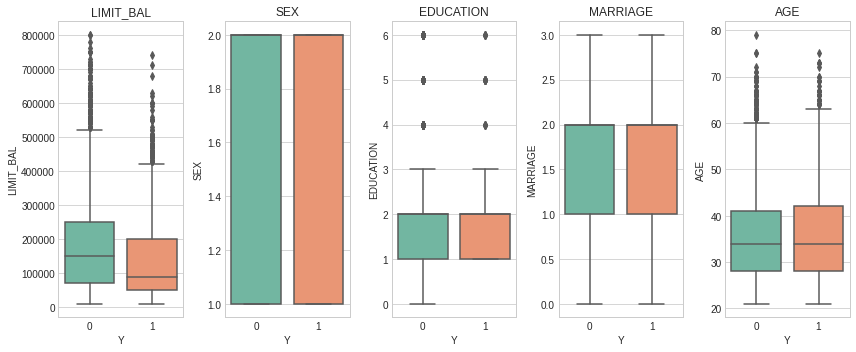

In [17]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

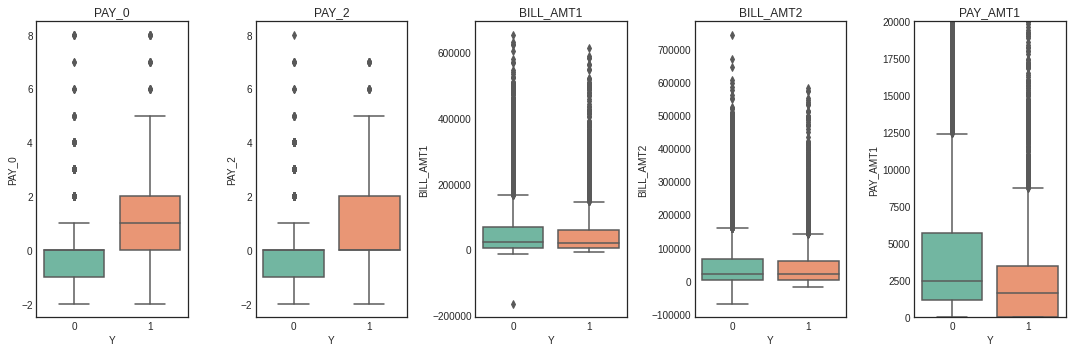

In [40]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(15, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

plt.ylim(0, 20000)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

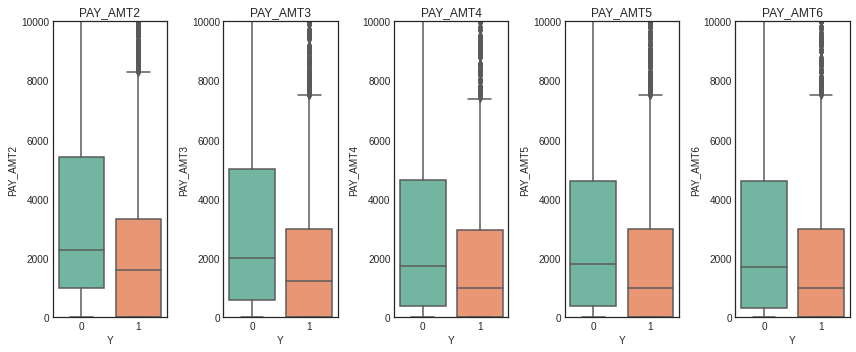

In [28]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[10:15].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
    axs[i].set_ylim(0, 10000)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

Меньше всего различаются коробчатые диаграммы по переменным `Sex`, `Education` и `Marriage`. Но классы по зависимой переменной `Y` неплохо разделяются по всем остальным объясняющим переменным.  

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

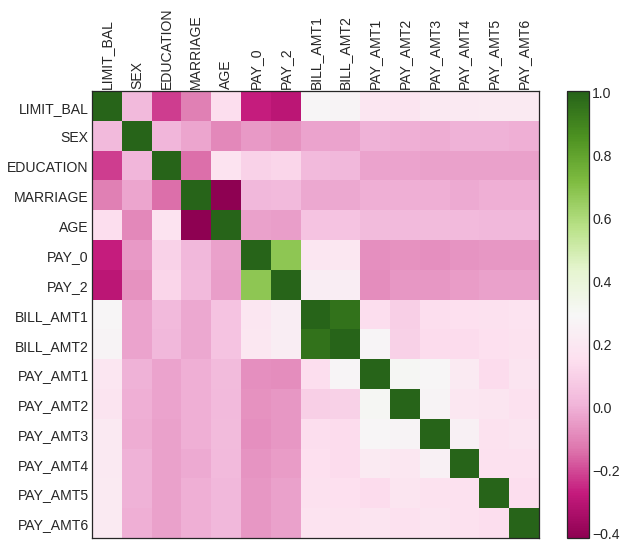

In [41]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [42]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
39,MARRIAGE,AGE,-0.417270,0.0
5,LIMIT_BAL,PAY_2,-0.297632,0.0
4,LIMIT_BAL,PAY_0,-0.271855,0.0
1,LIMIT_BAL,EDUCATION,-0.218273,0.0
27,EDUCATION,MARRIAGE,-0.144536,0.0
...,...,...,...,...
6,LIMIT_BAL,BILL_AMT1,0.281392,0.0
91,PAY_AMT1,PAY_AMT3,0.281398,0.0
90,PAY_AMT1,PAY_AMT2,0.305704,0.0
60,PAY_0,PAY_2,0.673600,0.0


# Методы снижения размерности  

Посмотрим, как работают методы снижения размерности:  

* регрессия на главные компоненты (PCR)   
* частный метод наименьших квадратов (PLS)  

Оба метода требуют предварительной стандартизации переменных.  

In [43]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :15].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = 0.0   Станд. отклонение = 1.0
Столбец 3: среднее = -0.0   Станд. отклонение = 1.0
Столбец 4: среднее = 0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = 0.0   Станд. отклонение = 1.0
Столбец 8: среднее = -0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0
Столбец 10: среднее = -0.0   Станд. отклонение = 1.0
Столбец 11: среднее = 0.0   Станд. отклонение = 1.0
Столбец 12: среднее = -0.0   Станд. отклонение = 1.0
Столбец 13: среднее = -0.0   Станд. отклонение = 1.0
Столбец 14: среднее = 0.0   Станд. отклонение = 1.0


## Метод частных наименьших квадратов  

Сначала посмотрим, как работает метод на всех наблюдениях обучающего набора.  

In [49]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=15, max_iter=1500)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF.Y.astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis=0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.138 0.085 0.113 0.045 0.046 0.028 0.034 0.014 0.042 0.047 0.049 0.046
 0.055 0.046 0.001] 
Общая сумма долей: 0.787


/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с $Y$, компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии уже не равняется 1.  

In [114]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=11)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.606838,0.393162
1,0.666887,0.333113
2,0.752375,0.247625
3,0.589223,0.410777
4,0.914751,0.085249
...,...,...
25495,0.541367,0.458633
25496,0.796814,0.203186
25497,1.044514,-0.044514
25498,0.790069,0.209931


In [115]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 24373), (1, 1127)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.  

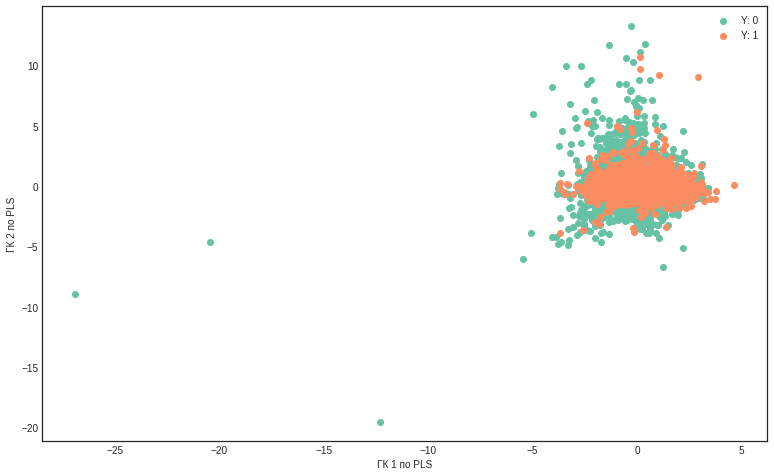

In [142]:
# график классов в пространстве ГК
plt.figure(figsize = (13,8))
plt.scatter(X_train_pls[DF['Y'] == 0][:, 3],
            X_train_pls[DF['Y'] == 0][:, 10], label='Y: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 3], 
            X_train_pls[DF['Y'] == 1][:, 10], label='Y: 1')

plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Я провел много экспериментов с разным количеством главных компонент и попробовал построить срезы, чтобы найти когда классы можно будет визуально разделить. Однако, понижение размерности не позволяет добиться визуального улучшения в разделении классов. 

По идеии из 15 зависимых компонент, 3  (`sex`, `marrige`, `education`) не позволяют различить два класса и 6 признаков коррелированны.

In [144]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=11)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)
score=list()
score.append(np.around(np.mean(acc_blocks), 3))
score_models=list()
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.8


## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом `penalty='l1'` в функции `LogisticRegression`.    

In [151]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [-1.465] 
Коэффициенты моделей для классов:
 [[-0.111 -0.061 -0.077 -0.081  0.066  0.678  0.197 -0.359  0.266 -0.193
  -0.159 -0.051 -0.067 -0.041 -0.036]]


Метод лассо позволяет обнулять коэффициенты, тем самым отбрасывая слабые объясняющие переменные, но в данном случае такого не произошло.  

In [153]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=my_seed+3,
                               penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
lasso_cv.C_

array([2.7825594])

In [154]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_lasso')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_lasso, перекрёстная проверка по 10 блокам
Acc = 0.811


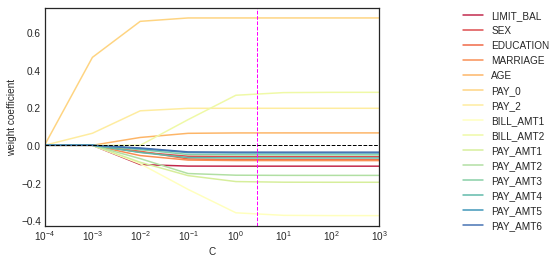

In [160]:
# график динамики коэффициентов в лассо-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, DF.columns)

Итак, судя по графикам, для значения гиперпараметра, дающего самую точную модель, ни один коэффициент при объясняющих переменных не обнуляется. Это подтверждает наблюдение, сделанное нами ещё на этапе предварительного анализа: все объясняющие переменные неплохо разделяют классы.   


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [161]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,0.800
1,logit_lasso,0.811


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается Лассо-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [162]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :15].values)
Y_pred = DF_predict.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89      3489
           1       0.71      0.24      0.36      1011

    accuracy                           0.81      4500
   macro avg       0.76      0.60      0.62      4500
weighted avg       0.79      0.81      0.77      4500



Итак, методом логистической регрессии со сжатием коэффициенты с L1
-регуляризацией мы получили идеально точную модель классификации трёх видов красных вин.  

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

